# Proyek Klasifikasi Gambar: [Plants Classification]
- **Nama:** [Dearmawan]
- **Email:** [dearmawantan@gmail.com]
- **ID Dicoding:** [dearmawan]

## **Sumber Dataset**
https://www.kaggle.com/datasets/marquis03/plants-classification

## **Import Semua Packages/Library yang Digunakan**

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mc172d5y1422","key":"2dd31032c8177b0f8d7de0feca54eefb"}'}

In [4]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset dari Kaggle
!kaggle datasets download -d marquis03/plants-classification
# Unzip file
!unzip plants-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/tobacco/tobacco190.jpg  
  inflating: train/tobacco/tobacco191.jpg  
  inflating: train/tobacco/tobacco192.jpg  
  inflating: train/tobacco/tobacco193.jpg  
  inflating: train/tobacco/tobacco194.jpg  
  inflating: train/tobacco/tobacco195.jpg  
  inflating: train/tobacco/tobacco196.jpg  
  inflating: train/tobacco/tobacco197.jpg  
  inflating: train/tobacco/tobacco198.jpg  
  inflating: train/tobacco/tobacco199.jpg  
  inflating: train/tobacco/tobacco2.jpg  
  inflating: train/tobacco/tobacco20.jpg  
  inflating: train/tobacco/tobacco200.jpg  
  inflating: train/tobacco/tobacco201.jpg  
  inflating: train/tobacco/tobacco202.jpg  
  inflating: train/tobacco/tobacco203.jpg  
  inflating: train/tobacco/tobacco204.jpg  
  inflating: train/tobacco/tobacco205.jpg  
  inflating: train/tobacco/tobacco206.jpg  
  inflating: train/tobacco/tobacco207.jpg  
  inflating: train/tobacco/tobacco208.jpg  
  inflating: train/tobacco/t

## **Gabungkan Data Train, Data Test dan Data Valid ke Direktori yang Sama**

In [5]:
import os
import shutil

# Direktori awal untuk train,test, dan valid
train_dir = "plants/train"
test_dir = "plants/test"
valid_dir = "plants/val"

# Direktori baru untuk dataset gabungan
combined_dir = "plants/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari valid
for category in os.listdir(valid_dir):
    category_dir = os.path.join(valid_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

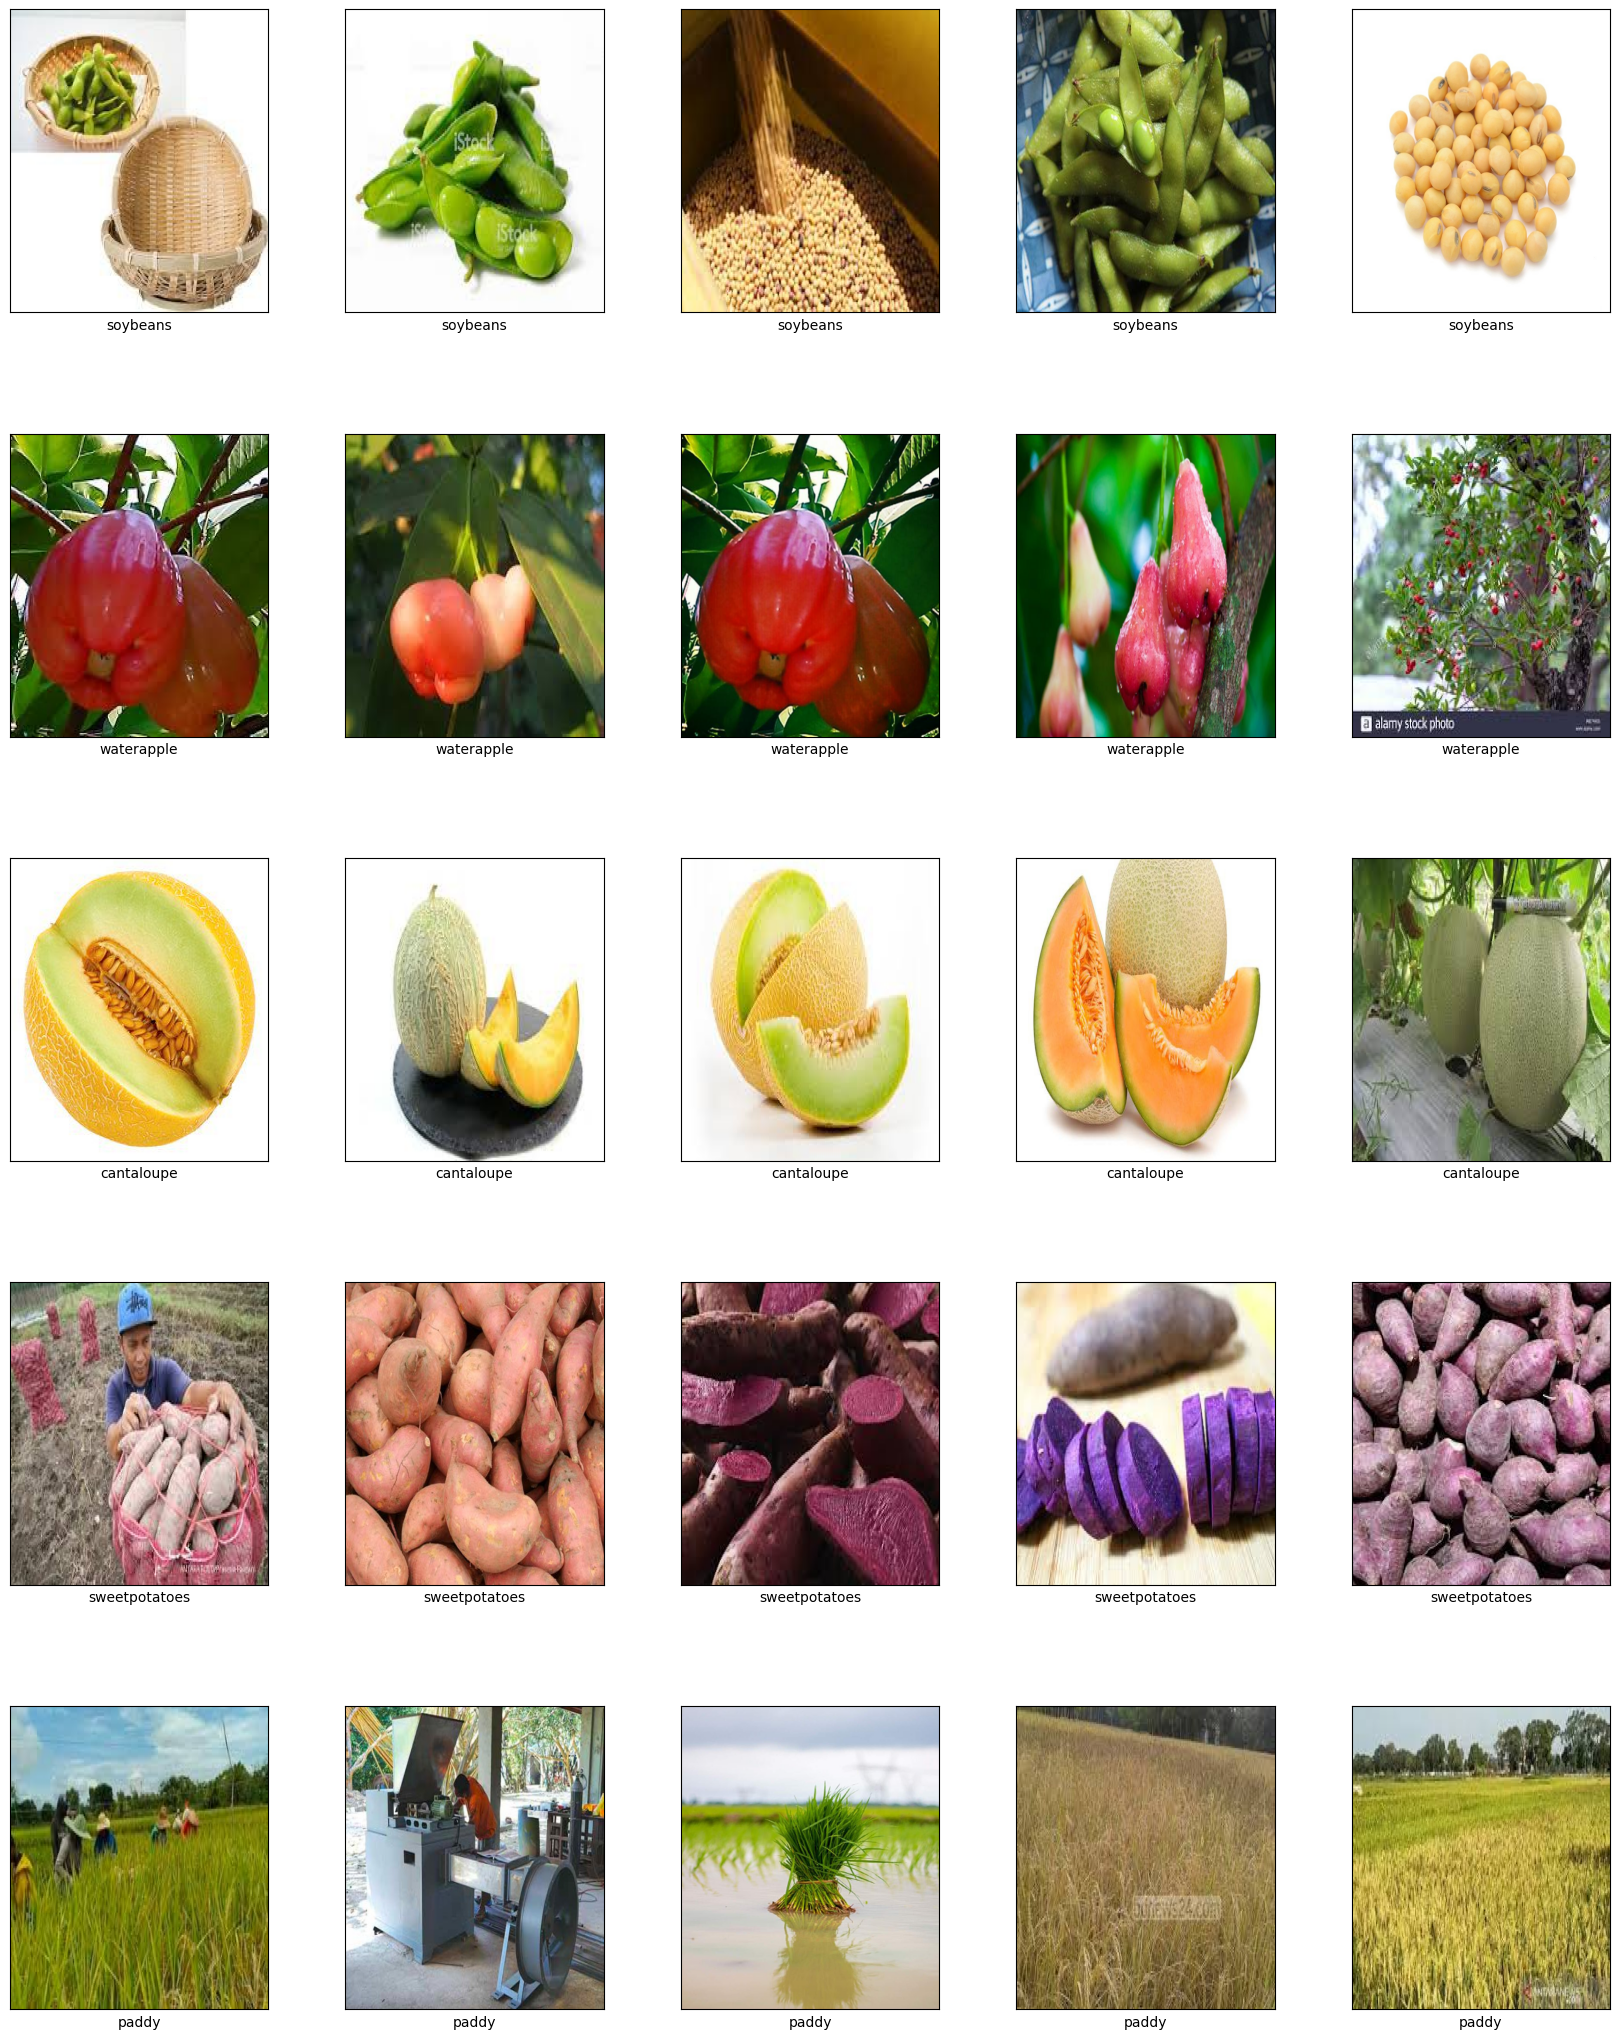

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "plants/"
path_sub = os.path.join(path, "dataset")

# Isi kamus lung_image dengan daftar gambar per kelas
for i in os.listdir(path_sub):
    class_path = os.path.join(path_sub, i)
    if os.path.isdir(class_path):  # Pastikan hanya direktori yang diproses
        # Ambil hanya file gambar (misalnya .jpg, .png)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if images:  # Pastikan ada gambar di kelas ini
            lung_image[i] = images

# Pilih 5 kelas secara acak untuk ditampilkan
num_classes_to_show = 5
selected_classes = np.random.choice(list(lung_image.keys()), num_classes_to_show, replace=False)

# Menampilkan secara acak 5 gambar di bawah setiap kelas yang dipilih
# Buat subplot dengan ukuran figure yang cukup besar
fig, axs = plt.subplots(num_classes_to_show, 5, figsize=(20, num_classes_to_show * 5))

for i, class_name in enumerate(selected_classes):
    # Pilih 5 gambar secara acak dari kelas ini
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        try:
            img = Image.open(img_path)  # Buka gambar tanpa konversi ke grayscale
            axs[i, j].imshow(img, aspect='auto')  # Tampilkan gambar dengan aspek asli
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        except Exception as e:
            print(f"Gagal membuka gambar {img_path}: {e}")
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
            axs[i, j].text(0.5, 0.5, "Gambar Tidak Dapat Dibuka", ha='center', va='center')

# Atur margin manual agar label tidak bertumpuk
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.3)
plt.show()

#**Cek Resolusi gambar pada data set**

In [7]:
import os
from PIL import Image

# Tentukan path sumber dataset
path = "plants/"
path_sub = os.path.join(path, "dataset")

# Set untuk menyimpan semua resolusi yang ditemukan
resolutions = set()

# Iterasi melalui setiap kelas dan gambar untuk mengumpulkan resolusi
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya direktori yang diproses
        # Ambil hanya file gambar (misalnya .jpg, .png)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        for image_name in images:
            img_path = os.path.join(class_path, image_name)
            try:
                img = Image.open(img_path)
                resolution = img.size  # Mengambil resolusi (lebar, tinggi)
                resolutions.add(resolution)
            except Exception as e:
                print(f"Gagal membuka gambar {img_path}: {e}")

# Tampilkan hasil
print("Resolusi yang ditemukan:", resolutions)
if len(resolutions) == 1:
    print("Semua gambar memiliki resolusi yang seragam:", resolutions.pop())
else:
    print("Resolusi tidak seragam. Berikut adalah resolusi yang berbeda:", resolutions)

# Opsional: Tampilkan jumlah gambar per resolusi
resolution_counts = {}
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        for image_name in images:
            img_path = os.path.join(class_path, image_name)
            try:
                img = Image.open(img_path)
                resolution = img.size
                resolution_counts[resolution] = resolution_counts.get(resolution, 0) + 1
            except Exception as e:
                continue

print("\nJumlah gambar per resolusi:")
for resolution, count in resolution_counts.items():
    print(f"Resolusi {resolution}: {count} gambar")

Resolusi yang ditemukan: {(600, 522), (277, 277), (1200, 1600), (1099, 614), (1032, 561), (315, 160), (500, 700), (788, 609), (580, 580), (360, 540), (749, 501), (1085, 1390), (708, 320), (960, 721), (1200, 782), (450, 470), (336, 448), (1440, 800), (1600, 1167), (770, 560), (468, 375), (448, 280), (320, 360), (585, 780), (902, 1390), (640, 450), (702, 282), (1300, 905), (3344, 2224), (1000, 613), (1200, 638), (450, 326), (900, 1200), (2000, 1402), (550, 413), (596, 380), (1280, 667), (1289, 1390), (450, 1000), (830, 467), (646, 646), (334, 151), (200, 300), (280, 180), (399, 280), (1200, 674), (257, 196), (800, 1198), (650, 536), (348, 314), (679, 679), (728, 455), (466, 306), (800, 560), (820, 538), (150, 335), (350, 360), (705, 408), (670, 450), (421, 420), (209, 241), (1118, 726), (600, 800), (685, 1024), (1628, 568), (640, 607), (480, 326), (1000, 999), (500, 304), (680, 500), (1000, 770), (800, 416), (298, 169), (940, 576), (512, 278), (652, 438), (410, 410), (250, 129), (1300, 8

- Dapat dilihat bahwa gambar tidak seragam

## **Plot gambar sampel untuk semua kelas**

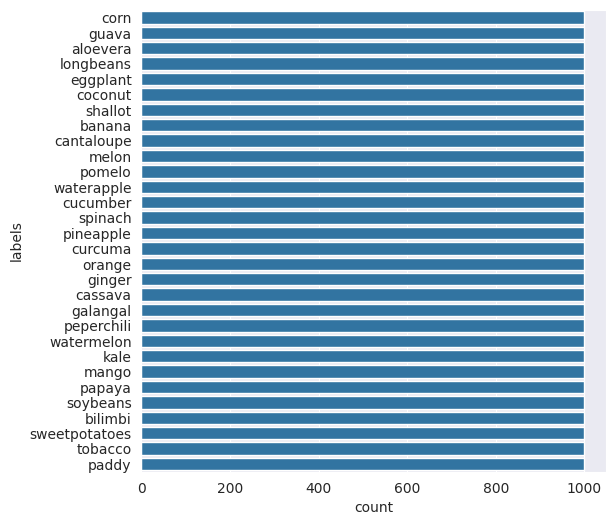

In [8]:
# Define source path
lung_path = "plants/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Augmentation**

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator dengan berbagai augmentasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,             # Rotasi acak hingga 270 derajat
    brightness_range=[0.8, 1.3],    # Kecerahan acak
    shear_range=0.2,                # Pergeseran melengkung (shear)
    width_shift_range=0.2,         # Pergeseran lebar
    height_shift_range=0.2,        # Pergeseran tinggi
    zoom_range=0.2,                # Zoom acak
    horizontal_flip=True,          # Balik horizontal
    vertical_flip=True,            # Balik vertikal (atas-bawah)
    fill_mode='nearest'            # Metode pengisian setelah transformasi
)

# Contoh penggunaan pada gambar tunggal
def augment_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Ubah jadi batch size 1

    # Menghasilkan batch gambar hasil augmentasi
    augmented_iter = datagen.flow(img_array, batch_size=1)

    # Ambil satu batch hasil augmentasi
    augmented_img = next(augmented_iter)[0].astype('uint8')

    return augmented_img


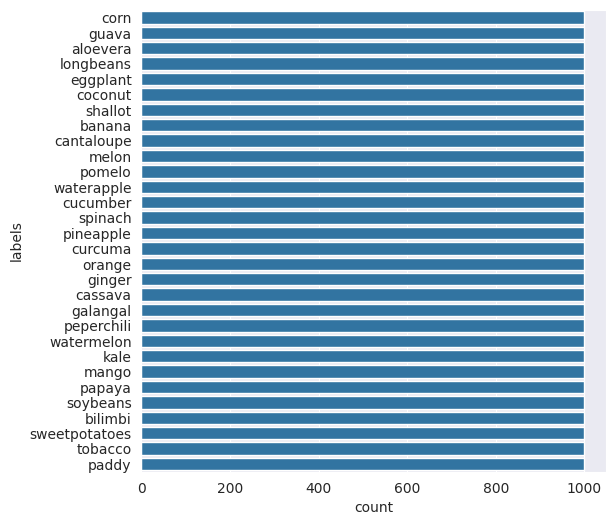

In [10]:
# Define source path
lung_path = "plants/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [11]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'plants/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
aloevera         1000
banana           1000
bilimbi          1000
cantaloupe       1000
cassava          1000
coconut          1000
corn             1000
cucumber         1000
curcuma          1000
eggplant         1000
galangal         1000
ginger           1000
guava            1000
kale             1000
longbeans        1000
mango            1000
melon            1000
orange           1000
paddy            1000
papaya           1000
peperchili       1000
pineapple        1000
pomelo           1000
shallot          1000
soybeans         1000
spinach          1000
sweetpotatoes    1000
tobacco          1000
waterapple       1000
watermelon       1000
dtype: int64

In [12]:

# Memisahkan data menjadi train (80%) dan sisa (20%)
X = df['path']
y = df['labels']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=300, stratify=y)

# Dari sisa 20%, kita bagi dua: val (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=300, stratify=y_temp)

# Menggabungkan ke masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Gabungkan semua ke satu dataframe final (opsional kalau kamu mau pakai ini nanti)
df_all = pd.concat([df_tr, df_val, df_te]).reset_index(drop=True)

# Print hasil untuk melihat panjang masing-masing set
print('Train size:', len(df_tr))
print('Validation size:', len(df_val))
print('Test size:', len(df_te))

Train size: 24000
Validation size: 3000
Test size: 3000


In [13]:
# Gabungkan semua DataFrame: train, validation, dan test
df_all = pd.concat([df_tr, df_val, df_te], ignore_index=True)

# Print distribusi data berdasarkan set dan label
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek 5 sample data secara acak
print(df_all.sample(5))



set   labels       
test  aloevera         100
      banana           100
      bilimbi          100
      cantaloupe       100
      cassava          100
                      ... 
val   spinach          100
      sweetpotatoes    100
      tobacco          100
      waterapple       100
      watermelon       100
Length: 90, dtype: int64 


                                              path      labels    set
8087             plants/dataset/melon/melon122.jpg       melon  train
7234   plants/dataset/watermelon/watermelon385.jpg  watermelon  train
15263      plants/dataset/cucumber/cucumber412.jpg    cucumber  train
11997        plants/dataset/bilimbi/bilimbi959.jpg     bilimbi  train
2191       plants/dataset/eggplant/eggplant940.jpg    eggplant  train


In [14]:
import os
import shutil
from tqdm import tqdm

# Path asal dan tujuan
datasource_path = "plants/dataset/"
dataset_path = "Dataset-Final/"

# Mulai proses salin
for index, row in tqdm(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']  # Path asli dari gambar

    # Pastikan file path valid (fallback kalau sebelumnya tidak lengkap)
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], os.path.basename(file_path))

    # Buat folder tujuan jika belum ada
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Tentukan nama file tujuan
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file jika belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)


100%|██████████| 30000/30000 [00:14<00:00, 2003.47it/s]


# **Image Data Generator**

In [15]:
import os

BASE_DIR = "Dataset-Final"
sets = ['train', 'val', 'test']

for s in sets:
    print(f"\nJumlah gambar untuk set: {s.upper()}")
    set_path = os.path.join(BASE_DIR, s)

    # Ambil semua label (folder) dalam set ini
    labels = os.listdir(set_path)

    for label in labels:
        label_path = os.path.join(set_path, label)
        if os.path.isdir(label_path):
            count = len(os.listdir(label_path))
            print(f" - {label}: {count} gambar")



Jumlah gambar untuk set: TRAIN
 - corn: 800 gambar
 - guava: 800 gambar
 - aloevera: 800 gambar
 - longbeans: 800 gambar
 - eggplant: 800 gambar
 - coconut: 800 gambar
 - shallot: 800 gambar
 - banana: 800 gambar
 - cantaloupe: 800 gambar
 - melon: 800 gambar
 - pomelo: 800 gambar
 - waterapple: 800 gambar
 - cucumber: 800 gambar
 - spinach: 800 gambar
 - pineapple: 800 gambar
 - curcuma: 800 gambar
 - orange: 800 gambar
 - ginger: 800 gambar
 - cassava: 800 gambar
 - galangal: 800 gambar
 - peperchili: 800 gambar
 - watermelon: 800 gambar
 - kale: 800 gambar
 - mango: 800 gambar
 - papaya: 800 gambar
 - soybeans: 800 gambar
 - bilimbi: 800 gambar
 - sweetpotatoes: 800 gambar
 - tobacco: 800 gambar
 - paddy: 800 gambar

Jumlah gambar untuk set: VAL
 - corn: 100 gambar
 - guava: 100 gambar
 - aloevera: 100 gambar
 - longbeans: 100 gambar
 - eggplant: 100 gambar
 - coconut: 100 gambar
 - shallot: 100 gambar
 - banana: 100 gambar
 - cantaloupe: 100 gambar
 - melon: 100 gambar
 - pomelo: 

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path direktori dataset
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR   = "Dataset-Final/val/"
TEST_DIR  = "Dataset-Final/test/"

# ImageDataGenerator untuk training dan validasi
datagen = ImageDataGenerator(
    rescale=1./255
)

# Test tetap hanya rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",          # karena gambar tanaman berwarna
    class_mode='categorical',  # karena >2 kelas
    shuffle=True
)

# Validation Generator
validation_generator = datagen.flow_from_directory(
    VAL_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)


Found 24000 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.


## Modelling

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Membuat model Sequential
model = Sequential([
    # Layer 1: Conv2D + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer 2: Conv2D + MaxPooling
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer 3: Conv2D + MaxPooling
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer 4: Conv2D + MaxPooling
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten untuk mengubah ke vektor
    Flatten(),

    # Fully Connected Layer
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Output Layer (30 kelas)
    Dense(30, activation='softmax')  # 30 kelas sesuai dengan jumlah kelas di dataset
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,593,054 (13.71 MB)

 Trainable params: 3,592,350 (13.70 MB)

 Non-trainable params: 704 (2.75 KB)

In [22]:
# Definisikan Callback Kustom
class CustomModelCheckpoint(Callback):
    def __init__(self, save_path="saved_model/CNN_Awal", max_gap=0.02, loss_tolerance=0.01):
        super(CustomModelCheckpoint, self).__init__()
        self.save_path = save_path
        self.max_gap = max_gap
        self.loss_tolerance = loss_tolerance
        self.best_val_acc = 0
        self.best_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy", 0)
        train_acc = logs.get("accuracy", 0)
        val_loss = logs.get("val_loss", float("inf"))

        if (val_acc > self.best_val_acc and abs(train_acc - val_acc) <= self.max_gap
            and val_loss < self.best_val_loss):
            self.best_val_acc = val_acc
            self.best_val_loss = val_loss
            tf.saved_model.save(self.model, self.save_path)
            print(f"Model disimpan di {self.save_path} dengan val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}, dan gap: {abs(train_acc - val_acc):.4f}")

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy", 0)
        train_acc = logs.get("accuracy", 0)

        if val_acc >= 0.96 and train_acc >= 0.96:
            print(f"\nTraining dihentikan karena train_acc ({train_acc:.4f}) dan val_acc ({val_acc:.4f}) >= 0.96")
            self.model.stop_training = True
# Definisikan Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
custom_checkpoint = CustomModelCheckpoint(save_path="saved_model/CNN_Awal")
custom_early_stopping = CustomEarlyStopping()

In [23]:
# Training model dengan callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, custom_checkpoint, custom_early_stopping],
    verbose=1
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.1181 - loss: 3.6224 - val_accuracy: 0.2850 - val_loss: 2.3891 - learning_rate: 0.0010
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2641 - loss: 2.5385Model disimpan di saved_model/CNN_Awal dengan val_acc: 0.2560, val_loss: 2.5557, dan gap: 0.0195
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s 87ms/step - accuracy: 0.2641 - loss: 2.5385 - val_accuracy: 0.2560 - val_loss: 2.5557 - learning_rate: 0.0010
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - accuracy: 0.3295 - loss: 2.2770 - val_accuracy: 0.3760 - val_loss: 2.1151 - learning_rate: 0.0010
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step - accuracy: 0.3830 - loss: 2.0842 - val_accuracy: 0.3237 - val_loss: 2.4061 - learning_rate: 0.0010
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4412 - loss: 1.8748Model disimpan di saved_model/CNN_Awal dengan val_acc: 0.4570, val_loss: 1.8675, dan gap: 0.0068
750/750 ━━━━━━━━━━━━━━━━━━━━ 

- Di sini saya sudah mendapatkan akurasi sebesar 91% akan tetapi val akurasinya masih 80% maka dari itu saya menggunakan Tranfer Learning

#**Transfer Learning**

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Path direktori dataset (sesuai dengan kode sebelumnya)
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR = "Dataset-Final/val/"
TEST_DIR = "Dataset-Final/test/"

# Load base model MobileNet (pre-trained pada ImageNet)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Membekukan layer base model agar tidak dilatih ulang
base_model.trainable = False

# Membuat model Sequential
model = Sequential([
    # Base model (MobileNet)
    base_model,

    # Tambahan Conv2D layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    # Tambahan MaxPooling layer
    MaxPooling2D(2, 2),

    # Tambahan Conv2D layer kedua
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    # Tambahan MaxPooling layer kedua
    MaxPooling2D(2, 2),

    # GlobalAveragePooling untuk mengurangi dimensi
    GlobalAveragePooling2D(),

    # Fully Connected Layer
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Output Layer (30 kelas sesuai dataset)
    Dense(30, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
model.summary()

# Definisikan Callbacks (menggunakan yang sudah ada di kode sebelumnya)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5,min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
custom_checkpoint = CustomModelCheckpoint(save_path="saved_model/transfer_learning")
custom_early_stopping = CustomEarlyStopping()

# Training model dengan data generator yang sudah dibuat sebelumnya
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, custom_checkpoint, custom_early_stopping],
    verbose=1
)

<ipython-input-24-dde63b348f2d>:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 64)       │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098,462 (15.63 MB)

 Trainable params: 869,214 (3.32 MB)

 Non-trainable params: 3,229,248 (12.32 MB)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 78s 93ms/step - accuracy: 0.3885 - loss: 2.1772 - val_accuracy: 0.6850 - val_loss: 1.0724 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7154 - loss: 0.9762Model disimpan di saved_model/transfer_learning dengan val_acc: 0.7163, val_loss: 0.9399, dan gap: 0.0038
750/750 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.7154 - loss: 0.9762 - val_accuracy: 0.7163 - val_loss: 0.9399 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.7862 - loss: 0.7120 - val_accuracy: 0.7353 - val_loss: 0.9044 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.8223 - loss: 0.5730 - val_accuracy: 0.7723 - val_loss: 0.7891 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 86ms/step - accuracy: 0.8525 - loss: 0.4507 - val_accuracy: 0.7813 - val_loss: 0.7527 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/

- Setelah melakukan Tranfer learning saya melihat ada  kenaikan pada akurasi dan val akurasinya , akan tetapi val akurasinya masih belum mencapai 95% maka dari itu saya akan coba menggunakan Fine tunning.

In [25]:
# Fine-tuning: Membuka beberapa layer base model untuk pelatihan
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Bekukan semua kecuali 20 layer terakhir
    layer.trainable = False

# Kompilasi ulang model dengan learning rate kecil
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate kecil untuk fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Pelatihan fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=15,  # Jumlah epoch lebih kecil untuk fine-tuning
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, custom_checkpoint, custom_early_stopping],
    verbose=1
)

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.7883 - loss: 0.8698 - val_accuracy: 0.7737 - val_loss: 0.9889 - learning_rate: 1.0000e-05
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 93ms/step - accuracy: 0.8344 - loss: 0.5858 - val_accuracy: 0.7973 - val_loss: 0.8827 - learning_rate: 1.0000e-05
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.8589 - loss: 0.4918 - val_accuracy: 0.8113 - val_loss: 0.7955 - learning_rate: 1.0000e-05
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 69s 92ms/step - accuracy: 0.8722 - loss: 0.4125 - val_accuracy: 0.8223 - val_loss: 0.7541 - learning_rate: 1.0000e-05
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step - accuracy: 0.8915 - loss: 0.3224 - val_accuracy: 0.8313 - val_loss: 0.7229 - learning_rate: 1.0000e-05
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 94ms/step - accuracy: 0.8991 - loss: 0.2965 - val_accuracy: 0.8363 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/ste

- Di sini bisa dilihat niali val akurasinya tidak dapat mencapai angka 95%

## **Evaluasi dan Visualisasi**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step

Classification Report:
               precision    recall  f1-score   support

     aloevera       0.91      0.94      0.93       100
       banana       0.92      0.96      0.94       100
      bilimbi       0.89      0.88      0.88       100
   cantaloupe       0.39      0.24      0.30       100
      cassava       0.96      0.93      0.94       100
      coconut       0.93      0.99      0.96       100
         corn       0.96      0.85      0.90       100
     cucumber       0.94      0.87      0.90       100
      curcuma       0.86      0.89      0.88       100
     eggplant       0.85      0.85      0.85       100
     galangal       0.87      0.90      0.89       100
       ginger       0.85      0.83      0.84       100
        guava       0.87      0.89      0.88       100
         kale       0.81      0.89      0.85       100
    longbeans       0.87      0.90      0.88       100
        mango       0.81      0.86      0.83       

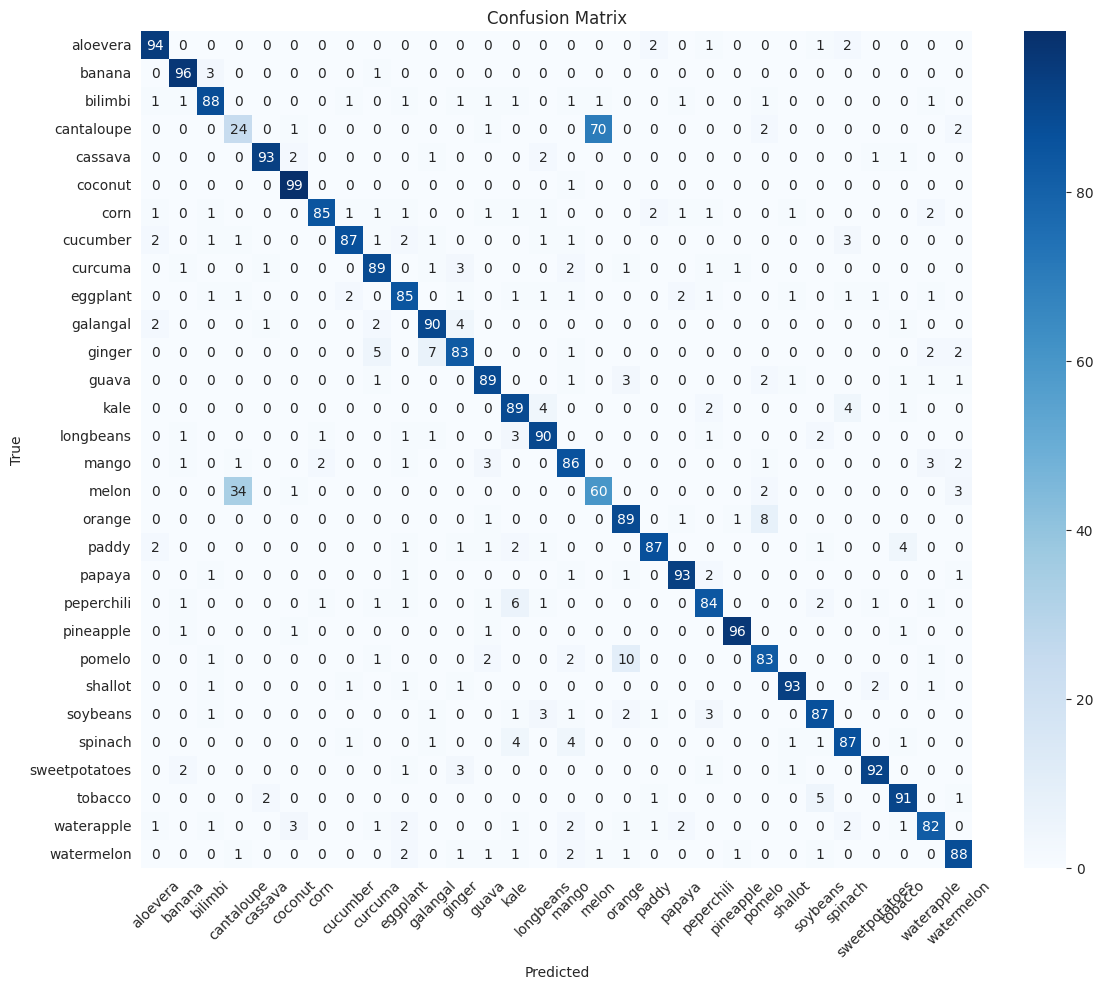

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Prediksi pada test set untuk analisis lebih lanjut
test_generator.reset()  # Reset generator untuk memastikan urutan data benar
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

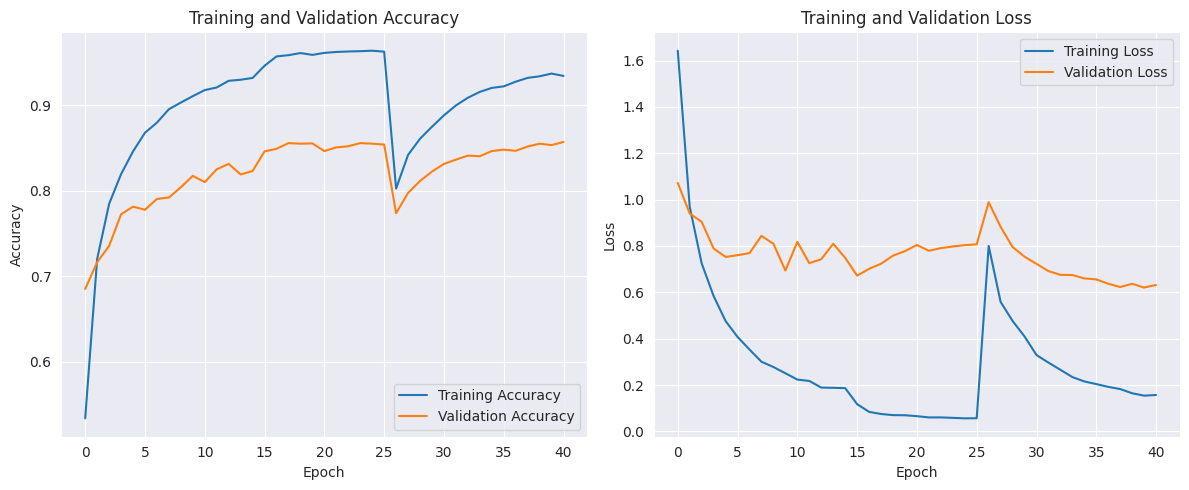

In [27]:
# == Visualisasi Akurasi dan Loss ==
# Menggabungkan history dari pelatihan awal dan fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [28]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8518 - loss: 0.5729
Test Accuracy: 0.8597, Test Loss: 0.6497


In [29]:
# == Analisis Overfitting/Underfitting ==
# Hitung selisih akurasi dan loss untuk mendeteksi overfitting/underfitting
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

print("\nAnalisis Overfitting/Underfitting:")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Cek apakah model overfit atau underfit
if final_train_acc > final_val_acc + 0.1:  # Selisih akurasi > 10%
    print("Model menunjukkan tanda-tanda overfitting: Akurasi training jauh lebih tinggi daripada akurasi validation.")
elif final_train_acc < 0.7 and final_val_acc < 0.7:  # Akurasi rendah (<70%)
    print("Model menunjukkan tanda-tanda underfitting: Akurasi training dan validation masih rendah.")
else:
    print("Model tampaknya memiliki performa yang baik: Tidak ada tanda-tanda overfitting atau underfitting yang signifikan.")


Analisis Overfitting/Underfitting:
Final Training Accuracy: 0.9343
Final Validation Accuracy: 0.8570
Final Training Loss: 0.1573
Final Validation Loss: 0.6320
Model tampaknya memiliki performa yang baik: Tidak ada tanda-tanda overfitting atau underfitting yang signifikan.


##**Konversi Model**

In [30]:
import tensorflow as tf
import os

# == 1. Menyimpan Model dalam Format SavedModel ==
# Direktori untuk menyimpan SavedModel
saved_model_dir = "saved_model/transfer_learning_final"
tf.saved_model.save(model, saved_model_dir)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_dir}")

Model berhasil disimpan dalam format SavedModel di: saved_model/transfer_learning_final


In [31]:
# == 2. Konversi ke Format TF-Lite ==

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengaktifkan optimasi default (opsi ini membantu mengurangi ukuran model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi model
tflite_model = converter.convert()

# Simpan model TF-Lite ke file
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model berhasil dikonversi ke format TF-Lite dan disimpan di: {tflite_model_path}")

Saved artifact at '/tmp/tmpwfgaajem'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_129')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  135587287414736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287416656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287416272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287412048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287410704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287416464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287414352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287409552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287411280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287413968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135587287

In [32]:
labels = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

In [34]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [35]:
# == 3. Konversi ke Format TFJS ==
import tensorflowjs as tfjs

# Direktori untuk menyimpan model TFJS
tfjs_model_dir = "tfjs_model"

# Konversi model ke format TFJS
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model berhasil dikonversi ke format TFJS dan disimpan di: {tfjs_model_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke format TFJS dan disimpan di: tfjs_model


## **Inference (Optional)**

Hasil Inferensi menggunakan TF-lite:
Kelas yang Diprediksi: guava
Probabilitas: 0.9998


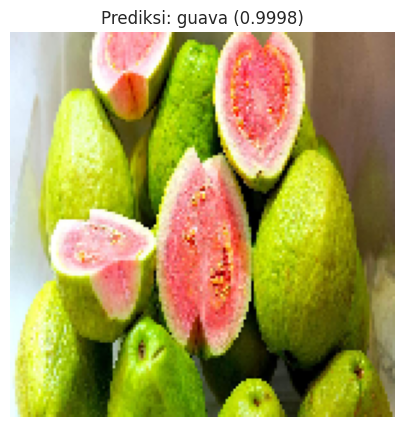

In [39]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# == Inference Menggunakan Model TF-Lite ==

# 1. Memuat model
saved_model_path = "model.tflite"
interpreter = tf.lite.Interpreter(model_path=saved_model_path)
interpreter.allocate_tensors()

# Mendapatkan detail input dan output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 2. Memuat dan memproses gambar untuk inferensi
# Ganti path ini dengan path gambar dari dataset test Anda
image_path = "Dataset-Final/test/guava/guava146.jpg"  # Contoh path gambar
image = load_img(image_path, target_size=(150, 150))  # Sesuaikan dengan ukuran input model
image_array = img_to_array(image)
image_array = image_array / 255.0  # Normalisasi (sesuai dengan preprocessing saat pelatihan)
image_array = np.expand_dims(image_array, axis=0)  # Tambah dimensi batch (1, 150, 150, 3)

# 3. Melakukan inferensi
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], image_array)
# Jalankan inferensi
interpreter.invoke()
# Ambil output
predictions = interpreter.get_tensor(output_details[0]['index'])
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_probability = predictions[0][predicted_class_index]

# 4. Mendapatkan label kelas
# Daftar kelas sesuai dengan dataset (sesuai urutan class_indices dari generator)
class_labels = list(test_generator.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# 5. Menampilkan hasil inferensi
print(f"Hasil Inferensi menggunakan TF-lite:")
print(f"Kelas yang Diprediksi: {predicted_class}")
print(f"Probabilitas: {predicted_probability:.4f}")

# Menampilkan gambar beserta prediksi
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(f"Prediksi: {predicted_class} ({predicted_probability:.4f})")
plt.axis('off')
plt.show()